In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy import stats
import joblib


In [2]:
data = pd.read_csv('cab_rides.csv')
weather = pd.read_csv('weather.csv')

In [3]:
data.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [4]:
weather.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49


# Data Preprocessing

In [5]:
data['date'] = pd.to_datetime(data['time_stamp']/1000, unit='s')
weather['date'] = pd.to_datetime(weather['time_stamp'], unit='s')

In [6]:
data.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,date
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16 09:30:07.890000105
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-27 02:00:23.677000046
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,2018-11-28 01:00:22.197999954
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,2018-11-30 04:53:02.749000072
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,2018-11-29 03:49:20.223000050


In [7]:
weather.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind,date
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25,2018-12-16 23:45:01
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32,2018-12-16 23:45:01
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07,2018-12-16 23:45:01
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09,2018-12-16 23:45:01
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49,2018-12-16 23:45:01


In [8]:
weather.drop(['pressure', 'humidity', 'wind'], axis=1, inplace=True)

In [9]:
data['merged'] = data['source'].astype('str') + ' ' + data['date'].dt.strftime('%Y-%m-%d').astype('str') + ' ' + data['date'].dt.strftime('%H:%M:%S').astype('str')
data['dest_merged'] = data['destination'].astype('str') + ' ' + data['date'].dt.strftime('%Y-%m-%d').astype('str') + ' ' + data['date'].dt.strftime('%H:%M:%S').astype('str')
weather['merged'] = weather['location'].astype('str') + ' ' + weather['date'].dt.strftime('%Y-%m-%d').astype('str') + ' ' + weather['date'].dt.strftime('%H:%M:%S').astype('str')

In [10]:
#Dropping the unrequired columns 
data.drop(['product_id','time_stamp','date'], axis=1, inplace=True)
weather.drop(['time_stamp','date'], axis=1, inplace=True)

In [11]:
data.head()

,distance,cab_type,destination,source,price,surge_multiplier,id,name,merged,dest_merged
0,0.44,Lyft,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,Shared,Haymarket Square 2018-12-16 09:30:07,North Station 2018-12-16 09:30:07
1,0.44,Lyft,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,Lux,Haymarket Square 2018-11-27 02:00:23,North Station 2018-11-27 02:00:23
2,0.44,Lyft,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,Lyft,Haymarket Square 2018-11-28 01:00:22,North Station 2018-11-28 01:00:22
3,0.44,Lyft,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,Lux Black XL,Haymarket Square 2018-11-30 04:53:02,North Station 2018-11-30 04:53:02
4,0.44,Lyft,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,Lyft XL,Haymarket Square 2018-11-29 03:49:20,North Station 2018-11-29 03:49:20


In [12]:
weather.head()

,temp,location,clouds,rain,merged
0,42.42,Back Bay,1.0,0.1228,Back Bay 2018-12-16 23:45:01
1,42.43,Beacon Hill,1.0,0.1846,Beacon Hill 2018-12-16 23:45:01
2,42.50,Boston University,1.0,0.1089,Boston University 2018-12-16 23:45:01
3,42.11,Fenway,1.0,0.0969,Fenway 2018-12-16 23:45:01
4,43.13,Financial District,1.0,0.1786,Financial District 2018-12-16 23:45:01


In [13]:
merged_data = pd.merge(data,weather, how='inner', on='merged')
merged_data

,distance,cab_type,destination,source,price,surge_multiplier,id,name,merged,dest_merged,temp,location,clouds,rain
0,0.55,Uber,South Station,Theatre District,7.0,1.0,74b72f4c-28bc-4640-a427-ec60b4b11f82,UberX,Theatre District 2018-11-28 17:32:07,South Station 2018-11-28 17:32:07,41.47,Theatre District,0.85,NaN
1,1.57,Uber,North End,Theatre District,18.0,1.0,e5aa2477-afb5-4b83-a69d-18ee7d2bfd1d,Black,Theatre District 2018-11-28 17:32:07,North End 2018-11-28 17:32:07,41.47,Theatre District,0.85,NaN
2,2.12,Lyft,Northeastern University,Theatre District,10.5,1.0,4d24470f-167a-4d1f-9cab-c123a0713491,Lyft,Theatre District 2018-11-28 17:32:07,Northeastern University 2018-11-28 17:32:07,41.47,Theatre District,0.85,NaN
3,2.12,Lyft,Northeastern University,Theatre District,7.0,1.0,7902bfaf-5987-499b-9c04-222f4182c581,Shared,Theatre District 2018-11-28 17:32:07,Northeastern University 2018-11-28 17:32:07,41.47,Theatre District,0.85,NaN
4,2.12,Lyft,Northeastern University,Theatre District,16.5,1.0,91129083-ed19-41fd-b16a-06c729ff0790,Lyft XL,Theatre District 2018-11-28 17:32:07,Northeastern University 2018-11-28 17:32:07,41.47,Theatre District,0.85,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3861,0.64,Lyft,West End,Haymarket Square,27.5,1.0,06fb0785-132d-4d59-a147-00655bc1b8f9,Lux Black XL,Haymarket Square 2018-11-26 06:29:03,West End 2018-11-26 06:29:03,40.60,Haymarket Square,1.00,NaN
3862,0.64,Lyft,West End,Haymarket Square,16.5,1.0,2be8dbc1-2a40-43e4-9e69-691420768750,Lux Black,Haymarket Square 2018-11-26 06:29:03,West End 2018-11-26 06:29:03,40.60,Haymarket Square,1.00,NaN
3863,0.49,Uber,North Station,Haymarket Square,7.0,1.0,9a79355e-26e1-4f81-936e-9fa3aa06f509,UberPool,Haymarket Square 2018-11-28 10:06:24,North Station 2018-11-28 10:06:24,33.18,Haymarket Square,0.14,NaN
3864,0.49,Uber,North Station,Haymarket Square,7.0,1.0,f92fafbf-d78b-410b-a957-f15af2022518,UberX,Haymarket Square 2018-11-28 10:06:24,North Station 2018-11-28 10:06:24,33.18,Haymarket Square,0.14,NaN


In [14]:
merged_data.head()

,distance,cab_type,destination,source,price,surge_multiplier,id,name,merged,dest_merged,temp,location,clouds,rain
0,0.55,Uber,South Station,Theatre District,7.0,1.0,74b72f4c-28bc-4640-a427-ec60b4b11f82,UberX,Theatre District 2018-11-28 17:32:07,South Station 2018-11-28 17:32:07,41.47,Theatre District,0.85,NaN
1,1.57,Uber,North End,Theatre District,18.0,1.0,e5aa2477-afb5-4b83-a69d-18ee7d2bfd1d,Black,Theatre District 2018-11-28 17:32:07,North End 2018-11-28 17:32:07,41.47,Theatre District,0.85,NaN
2,2.12,Lyft,Northeastern University,Theatre District,10.5,1.0,4d24470f-167a-4d1f-9cab-c123a0713491,Lyft,Theatre District 2018-11-28 17:32:07,Northeastern University 2018-11-28 17:32:07,41.47,Theatre District,0.85,NaN
3,2.12,Lyft,Northeastern University,Theatre District,7.0,1.0,7902bfaf-5987-499b-9c04-222f4182c581,Shared,Theatre District 2018-11-28 17:32:07,Northeastern University 2018-11-28 17:32:07,41.47,Theatre District,0.85,NaN
4,2.12,Lyft,Northeastern University,Theatre District,16.5,1.0,91129083-ed19-41fd-b16a-06c729ff0790,Lyft XL,Theatre District 2018-11-28 17:32:07,Northeastern University 2018-11-28 17:32:07,41.47,Theatre District,0.85,NaN


In [15]:
merged_data2 = pd.merge(merged_data,weather, how='inner', left_on='dest_merged', right_on='merged')
merged_data2

,distance,cab_type,destination,source,price,surge_multiplier,id,name,merged_x,dest_merged,temp_x,location_x,clouds_x,rain_x,temp_y,location_y,clouds_y,rain_y,merged_y
0,0.55,Uber,South Station,Theatre District,7.0,1.0,74b72f4c-28bc-4640-a427-ec60b4b11f82,UberX,Theatre District 2018-11-28 17:32:07,South Station 2018-11-28 17:32:07,41.47,Theatre District,0.85,NaN,41.61,South Station,0.85,NaN,South Station 2018-11-28 17:32:07
1,1.57,Uber,North End,Theatre District,18.0,1.0,e5aa2477-afb5-4b83-a69d-18ee7d2bfd1d,Black,Theatre District 2018-11-28 17:32:07,North End 2018-11-28 17:32:07,41.47,Theatre District,0.85,NaN,41.40,North End,0.85,NaN,North End 2018-11-28 17:32:07
2,1.75,Lyft,North End,Beacon Hill,26.0,1.0,75924e6f-60ac-46c2-aa92-f93a61eca726,Lux Black XL,Beacon Hill 2018-11-28 17:32:07,North End 2018-11-28 17:32:07,41.30,Beacon Hill,0.85,NaN,41.40,North End,0.85,NaN,North End 2018-11-28 17:32:07
3,2.21,Uber,North End,Beacon Hill,18.5,1.0,064ac617-a425-43b0-9dbe-91e244c0af65,Black,Beacon Hill 2018-11-28 17:32:07,North End 2018-11-28 17:32:07,41.30,Beacon Hill,0.85,NaN,41.40,North End,0.85,NaN,North End 2018-11-28 17:32:07
4,2.21,Uber,North End,Beacon Hill,8.5,1.0,1bbd3878-eb88-46f9-badf-77a0090dcddb,UberX,Beacon Hill 2018-11-28 17:32:07,North End 2018-11-28 17:32:07,41.30,Beacon Hill,0.85,NaN,41.40,North End,0.85,NaN,North End 2018-11-28 17:32:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2614,1.18,Lyft,Haymarket Square,Financial District,13.5,1.0,614ab356-c34c-417b-95ec-82a965c4341f,Lux,Financial District 2018-11-26 06:29:03,Haymarket Square 2018-11-26 06:29:03,43.97,Financial District,1.00,NaN,40.60,Haymarket Square,1.00,NaN,Haymarket Square 2018-11-26 06:29:03
2615,1.18,Lyft,Haymarket Square,Financial District,27.5,1.0,7ce3b196-f348-4d2d-8b57-20753ff7aacd,Lux Black XL,Financial District 2018-11-26 06:29:03,Haymarket Square 2018-11-26 06:29:03,43.97,Financial District,1.00,NaN,40.60,Haymarket Square,1.00,NaN,Haymarket Square 2018-11-26 06:29:03
2616,1.18,Lyft,Haymarket Square,Financial District,10.5,1.0,906eeba2-d494-4fba-9f82-aad1b9f820bd,Lyft XL,Financial District 2018-11-26 06:29:03,Haymarket Square 2018-11-26 06:29:03,43.97,Financial District,1.00,NaN,40.60,Haymarket Square,1.00,NaN,Haymarket Square 2018-11-26 06:29:03
2617,0.64,Lyft,West End,Haymarket Square,27.5,1.0,06fb0785-132d-4d59-a147-00655bc1b8f9,Lux Black XL,Haymarket Square 2018-11-26 06:29:03,West End 2018-11-26 06:29:03,40.60,Haymarket Square,1.00,NaN,40.48,West End,1.00,NaN,West End 2018-11-26 06:29:03


In [16]:
merged_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2619 entries, 0 to 2618
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   distance          2619 non-null   float64
 1   cab_type          2619 non-null   object 
 2   destination       2619 non-null   object 
 3   source            2619 non-null   object 
 4   price             2395 non-null   float64
 5   surge_multiplier  2619 non-null   float64
 6   id                2619 non-null   object 
 7   name              2619 non-null   object 
 8   merged_x          2619 non-null   object 
 9   dest_merged       2619 non-null   object 
 10  temp_x            2619 non-null   float64
 11  location_x        2619 non-null   object 
 12  clouds_x          2619 non-null   float64
 13  rain_x            263 non-null    float64
 14  temp_y            2619 non-null   float64
 15  location_y        2619 non-null   object 
 16  clouds_y          2619 non-null   float64


In [17]:
merged_data2.drop(['id','merged_x','merged_y','dest_merged','location_x','location_y'],axis=1, inplace=True)
merged_data2.head()

,distance,cab_type,destination,source,price,surge_multiplier,name,temp_x,clouds_x,rain_x,temp_y,clouds_y,rain_y
0,0.55,Uber,South Station,Theatre District,7.0,1.0,UberX,41.47,0.85,NaN,41.61,0.85,NaN
1,1.57,Uber,North End,Theatre District,18.0,1.0,Black,41.47,0.85,NaN,41.40,0.85,NaN
2,1.75,Lyft,North End,Beacon Hill,26.0,1.0,Lux Black XL,41.30,0.85,NaN,41.40,0.85,NaN
3,2.21,Uber,North End,Beacon Hill,18.5,1.0,Black,41.30,0.85,NaN,41.40,0.85,NaN
4,2.21,Uber,North End,Beacon Hill,8.5,1.0,UberX,41.30,0.85,NaN,41.40,0.85,NaN


In [18]:
final_df = merged_data2.rename(columns={'temp_x':'source_temp', 'clouds_x':'source_clouds', 'rain_x':'source_rain', 'temp_y':'dest_temp', 'clouds_y':'dest_clouds', 'rain_y':'dest_rain'})
final_df.head()

,distance,cab_type,destination,source,price,surge_multiplier,name,source_temp,source_clouds,source_rain,dest_temp,dest_clouds,dest_rain
0,0.55,Uber,South Station,Theatre District,7.0,1.0,UberX,41.47,0.85,NaN,41.61,0.85,NaN
1,1.57,Uber,North End,Theatre District,18.0,1.0,Black,41.47,0.85,NaN,41.40,0.85,NaN
2,1.75,Lyft,North End,Beacon Hill,26.0,1.0,Lux Black XL,41.30,0.85,NaN,41.40,0.85,NaN
3,2.21,Uber,North End,Beacon Hill,18.5,1.0,Black,41.30,0.85,NaN,41.40,0.85,NaN
4,2.21,Uber,North End,Beacon Hill,8.5,1.0,UberX,41.30,0.85,NaN,41.40,0.85,NaN


In [19]:
final_df.isnull().any()

distance            False
cab_type            False
destination         False
source              False
price                True
surge_multiplier    False
name                False
source_temp         False
source_clouds       False
source_rain          True
dest_temp           False
dest_clouds         False
dest_rain            True
dtype: bool

C:\Users\Siddharth\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

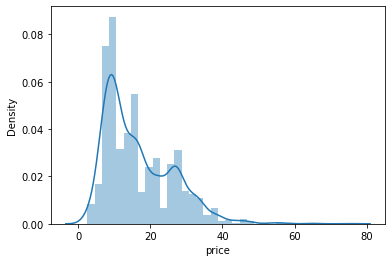

In [20]:
sns.distplot(final_df['price'].dropna())

In [21]:
final_df['price'].fillna(final_df['price'].median(), inplace=True)
final_df['source_rain'].fillna(0, inplace=True)
final_df['dest_rain'].fillna(0, inplace=True)

In [22]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2619 entries, 0 to 2618
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   distance          2619 non-null   float64
 1   cab_type          2619 non-null   object 
 2   destination       2619 non-null   object 
 3   source            2619 non-null   object 
 4   price             2619 non-null   float64
 5   surge_multiplier  2619 non-null   float64
 6   name              2619 non-null   object 
 7   source_temp       2619 non-null   float64
 8   source_clouds     2619 non-null   float64
 9   source_rain       2619 non-null   float64
 10  dest_temp         2619 non-null   float64
 11  dest_clouds       2619 non-null   float64
 12  dest_rain         2619 non-null   float64
dtypes: float64(9), object(4)
memory usage: 286.5+ KB


C:\Users\Siddharth\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

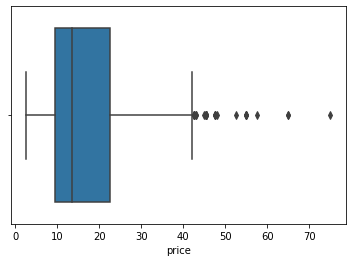

In [23]:
#Checking outliers
sns.boxplot(final_df['price'])

C:\Users\Siddharth\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='distance'>

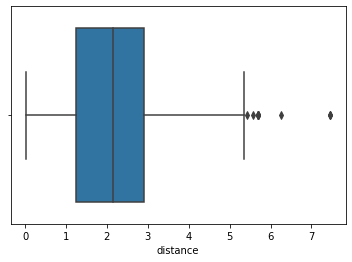

In [24]:
sns.boxplot(final_df['distance'])

C:\Users\Siddharth\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='surge_multiplier'>

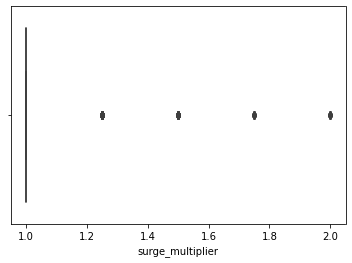

In [25]:
sns.boxplot(final_df['surge_multiplier'])

In [26]:
final_df.head()

,distance,cab_type,destination,source,price,surge_multiplier,name,source_temp,source_clouds,source_rain,dest_temp,dest_clouds,dest_rain
0,0.55,Uber,South Station,Theatre District,7.0,1.0,UberX,41.47,0.85,0.0,41.61,0.85,0.0
1,1.57,Uber,North End,Theatre District,18.0,1.0,Black,41.47,0.85,0.0,41.40,0.85,0.0
2,1.75,Lyft,North End,Beacon Hill,26.0,1.0,Lux Black XL,41.30,0.85,0.0,41.40,0.85,0.0
3,2.21,Uber,North End,Beacon Hill,18.5,1.0,Black,41.30,0.85,0.0,41.40,0.85,0.0
4,2.21,Uber,North End,Beacon Hill,8.5,1.0,UberX,41.30,0.85,0.0,41.40,0.85,0.0


In [27]:
final_df = final_df[['distance', 'cab_type', 'name','surge_multiplier','source', 'destination', 'source_temp', 'source_clouds', 'source_rain', 'dest_temp', 'dest_clouds', 'dest_rain','price' ]]
final_df

,distance,cab_type,name,surge_multiplier,source,destination,source_temp,source_clouds,source_rain,dest_temp,dest_clouds,dest_rain,price
0,0.55,Uber,UberX,1.0,Theatre District,South Station,41.47,0.85,0.0,41.61,0.85,0.0,7.0
1,1.57,Uber,Black,1.0,Theatre District,North End,41.47,0.85,0.0,41.40,0.85,0.0,18.0
2,1.75,Lyft,Lux Black XL,1.0,Beacon Hill,North End,41.30,0.85,0.0,41.40,0.85,0.0,26.0
3,2.21,Uber,Black,1.0,Beacon Hill,North End,41.30,0.85,0.0,41.40,0.85,0.0,18.5
4,2.21,Uber,UberX,1.0,Beacon Hill,North End,41.30,0.85,0.0,41.40,0.85,0.0,8.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2614,1.18,Lyft,Lux,1.0,Financial District,Haymarket Square,43.97,1.00,0.0,40.60,1.00,0.0,13.5
2615,1.18,Lyft,Lux Black XL,1.0,Financial District,Haymarket Square,43.97,1.00,0.0,40.60,1.00,0.0,27.5
2616,1.18,Lyft,Lyft XL,1.0,Financial District,Haymarket Square,43.97,1.00,0.0,40.60,1.00,0.0,10.5
2617,0.64,Lyft,Lux Black XL,1.0,Haymarket Square,West End,40.60,1.00,0.0,40.48,1.00,0.0,27.5


In [28]:
#Removing outliers based on price
z = np.abs(stats.zscore(final_df['price']))

In [29]:
final_df['z'] = z 
final_df

,distance,cab_type,name,surge_multiplier,source,destination,source_temp,source_clouds,source_rain,dest_temp,dest_clouds,dest_rain,price,z
0,0.55,Uber,UberX,1.0,Theatre District,South Station,41.47,0.85,0.0,41.61,0.85,0.0,7.0,1.034978
1,1.57,Uber,Black,1.0,Theatre District,North End,41.47,0.85,0.0,41.40,0.85,0.0,18.0,0.181632
2,1.75,Lyft,Lux Black XL,1.0,Beacon Hill,North End,41.30,0.85,0.0,41.40,0.85,0.0,26.0,1.066439
3,2.21,Uber,Black,1.0,Beacon Hill,North End,41.30,0.85,0.0,41.40,0.85,0.0,18.5,0.236933
4,2.21,Uber,UberX,1.0,Beacon Hill,North End,41.30,0.85,0.0,41.40,0.85,0.0,8.5,0.869076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2614,1.18,Lyft,Lux,1.0,Financial District,Haymarket Square,43.97,1.00,0.0,40.60,1.00,0.0,13.5,0.316072
2615,1.18,Lyft,Lux Black XL,1.0,Financial District,Haymarket Square,43.97,1.00,0.0,40.60,1.00,0.0,27.5,1.232341
2616,1.18,Lyft,Lyft XL,1.0,Financial District,Haymarket Square,43.97,1.00,0.0,40.60,1.00,0.0,10.5,0.647875
2617,0.64,Lyft,Lux Black XL,1.0,Haymarket Square,West End,40.60,1.00,0.0,40.48,1.00,0.0,27.5,1.232341


In [30]:
final_df = final_df[final_df.z<=3]
final_df.drop(['z'], axis=1, inplace=True)
final_df

C:\Users\Siddharth\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,distance,cab_type,name,surge_multiplier,source,destination,source_temp,source_clouds,source_rain,dest_temp,dest_clouds,dest_rain,price
0,0.55,Uber,UberX,1.0,Theatre District,South Station,41.47,0.85,0.0,41.61,0.85,0.0,7.0
1,1.57,Uber,Black,1.0,Theatre District,North End,41.47,0.85,0.0,41.40,0.85,0.0,18.0
2,1.75,Lyft,Lux Black XL,1.0,Beacon Hill,North End,41.30,0.85,0.0,41.40,0.85,0.0,26.0
3,2.21,Uber,Black,1.0,Beacon Hill,North End,41.30,0.85,0.0,41.40,0.85,0.0,18.5
4,2.21,Uber,UberX,1.0,Beacon Hill,North End,41.30,0.85,0.0,41.40,0.85,0.0,8.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2614,1.18,Lyft,Lux,1.0,Financial District,Haymarket Square,43.97,1.00,0.0,40.60,1.00,0.0,13.5
2615,1.18,Lyft,Lux Black XL,1.0,Financial District,Haymarket Square,43.97,1.00,0.0,40.60,1.00,0.0,27.5
2616,1.18,Lyft,Lyft XL,1.0,Financial District,Haymarket Square,43.97,1.00,0.0,40.60,1.00,0.0,10.5
2617,0.64,Lyft,Lux Black XL,1.0,Haymarket Square,West End,40.60,1.00,0.0,40.48,1.00,0.0,27.5


In [31]:
#Splitting into dependent and independent variables
x = final_df.iloc[:,0:12].values
x

array([[0.55, 'Uber', 'UberX', ..., 41.61, 0.85, 0.0],
       [1.57, 'Uber', 'Black', ..., 41.4, 0.85, 0.0],
       [1.75, 'Lyft', 'Lux Black XL', ..., 41.4, 0.85, 0.0],
       ...,
       [1.18, 'Lyft', 'Lyft XL', ..., 40.6, 1.0, 0.0],
       [0.64, 'Lyft', 'Lux Black XL', ..., 40.48, 1.0, 0.0],
       [0.64, 'Lyft', 'Lux Black', ..., 40.48, 1.0, 0.0]], dtype=object)

In [32]:
x.shape

(2595, 12)

In [33]:
y = final_df.iloc[:,-1].values
y

array([ 7. , 18. , 26. , ..., 10.5, 27.5, 16.5])

In [34]:
ct = ColumnTransformer([('oh',OneHotEncoder(drop='first'),[1,2,4,5])],remainder='passthrough')
x = ct.fit_transform(x)

In [35]:
import joblib
joblib.dump(ct,'onehot.save')

['onehot.save']

In [36]:
x.shape

(2595, 43)

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [38]:
x_train.shape

(2076, 43)

In [39]:
x_test.shape

(519, 43)

In [40]:
y_train.shape

(2076,)

In [41]:
y_test.shape

(519,)

# Model Building

In [42]:
rand = RandomForestRegressor(n_estimators=20, max_depth=17, random_state=10)
rand.fit(x_train, y_train)

RandomForestRegressor(max_depth=17, n_estimators=20, random_state=10)

In [43]:
y_pred = rand.predict(x_test)

In [44]:
r2_score(y_test,y_pred)

0.9535695714561604

In [45]:
rand.score(x_train,y_train)

0.9912930223069562

In [46]:
joblib.dump(rand,'model.save')

['model.save']

Model has been saved

In [47]:
final_df.iloc[0:1,:].values

array([[0.55, 'Uber', 'UberX', 1.0, 'Theatre District', 'South Station',
        41.47, 0.85, 0.0, 41.61, 0.85, 0.0, 7.0]], dtype=object)

In [53]:
#Demonstration of joblib 
trans = joblib.load('onehot.save')
x_dym = trans.transform([[0.55, 'Uber', 'UberX', 1.0, 'Theatre District', 'South Station', 41.47, 0.85, 0.0, 41.61, 0.85, 0.0]])
x_dym.shape

(1, 43)

In [54]:
load_model = joblib.load('model.save')
load_model.predict(x_dym)

array([7.175])